In [1]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, VGG19, ResNet50, InceptionV3, DenseNet201, NASNetLarge, Xception
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from keras import backend as K
import numpy as np
import argparse
import os
import cv2


In [2]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-2
EPOCHS = 20
BS = 32

In [3]:
maskPath = '/home/drake/projects/Sp21/ML/ML-6-Models/face-mask-detector/dataset/with_mask/'
noMaskPath = '/home/drake/projects/Sp21/ML/ML-6-Models/face-mask-detector/dataset/without_mask/'
data = []
labels = []
maskFiles = os.listdir(maskPath)
noMaskFiles = os.listdir(noMaskPath)

In [4]:
for img in maskFiles:
    image = load_img(maskPath + img, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

    # update the data and labels lists, respectively
    data.append(image)
    labels.append('with_mask')

In [5]:
for img in noMaskFiles:
    image = load_img(noMaskPath + img, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

    # update the data and labels lists, respectively
    data.append(image)
    labels.append('without_mask')

In [6]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [7]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [8]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)

In [9]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [10]:
mobile = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))
vgg = VGG19(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))
res = ResNet50(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))
incep = InceptionV3(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))
dense = DenseNet201(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))
nas = NASNetLarge(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3))) 
xcep = Xception(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

In [11]:
modelNames = ['mobile', 'vgg', 'res', 'incep', 'dense', 'nas', 'xcep']

In [12]:
headmobile = mobile.output
headmobile = AveragePooling2D(pool_size=(7, 7))(headmobile)
headmobile = Flatten(name="flatten")(headmobile)
headmobile = Dense(128, activation="relu")(headmobile)
headmobile = Dropout(0.5)(headmobile)
headmobile = Dense(2, activation="softmax")(headmobile)

In [13]:
headvgg = vgg.output
headvgg = AveragePooling2D(pool_size=(7, 7))(headvgg)
headvgg = Flatten(name="flatten")(headvgg)
headvgg = Dense(128, activation="relu")(headvgg)
headvgg = Dropout(0.5)(headvgg)
headvgg = Dense(2, activation="softmax")(headvgg)

In [14]:
headres = res.output
headres = AveragePooling2D(pool_size=(7, 7))(headres)
headres = Flatten(name="flatten")(headres)
headres = Dense(128, activation="relu")(headres)
headres = Dropout(0.5)(headres)
headres = Dense(2, activation="softmax")(headres)

In [15]:
headdense = dense.output
headdense = AveragePooling2D(pool_size=(7, 7))(headdense)
headdense = Flatten(name="flatten")(headdense)
headdense = Dense(128, activation="relu")(headdense)
headdense = Dropout(0.5)(headdense)
headdense = Dense(2, activation="softmax")(headdense)

In [16]:
headnas = nas.output
headnas = AveragePooling2D(pool_size=(7, 7))(headnas)
headnas = Flatten(name="flatten")(headnas)
headnas = Dense(128, activation="relu")(headnas)
headnas = Dropout(0.5)(headnas)
headnas = Dense(2, activation="softmax")(headnas)

In [17]:
headxcep = xcep.output
headxcep = AveragePooling2D(pool_size=(7, 7))(headxcep)
headxcep = Flatten(name="flatten")(headxcep)
headxcep = Dense(128, activation="relu")(headxcep)
headxcep = Dropout(0.5)(headxcep)
headxcep = Dense(2, activation="softmax")(headxcep)

In [18]:
modelmobile = Model(inputs=mobile.input, outputs=headmobile)
modelvgg = Model(inputs=vgg.input, outputs=headvgg)
modelres = Model(inputs=res.input, outputs=headres)
modeldense = Model(inputs=dense.input, outputs=headdense)
modelnas = Model(nas.input, outputs=headnas)
modelxcep = Model(inputs=xcep.input, outputs=headxcep)

In [19]:
for layer in mobile.layers:
    layer.trainable = False
for layer in vgg.layers:
    layer.trainable = False
for layer in res.layers:
    layer.trainable = False
for layer in incep.layers:
    layer.trainable = False
for layer in dense.layers:
    layer.trainable = False
for layer in nas.layers:
    layer.trainable = False
for layer in xcep.layers:
    layer.trainable = False

In [20]:

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
modelmobile.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy", f1_m, precision_m, recall_m])
modelvgg.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy", f1_m, precision_m, recall_m])
modelres.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy", f1_m, precision_m, recall_m])
modeldense.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy", f1_m, precision_m, recall_m])
modelnas.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy", f1_m, precision_m, recall_m])
modelxcep.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy", f1_m, precision_m, recall_m])

In [21]:
mobileHistory = modelmobile.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

Epoch 1/20
34/34 [==============================] - 18s 465ms/step - loss: 0.4082 - accuracy: 0.9141 - f1_m: 0.9147 - precision_m: 0.9147 - recall_m: 0.9147 - val_loss: 0.0129 - val_accuracy: 0.9964 - val_f1_m: 0.9964 - val_precision_m: 0.9964 - val_recall_m: 0.9964
Epoch 2/20
34/34 [==============================] - 16s 455ms/step - loss: 0.0342 - accuracy: 0.9949 - f1_m: 0.9949 - precision_m: 0.9949 - recall_m: 0.9949 - val_loss: 0.0353 - val_accuracy: 0.9855 - val_f1_m: 0.9857 - val_precision_m: 0.9857 - val_recall_m: 0.9857
Epoch 3/20
34/34 [==============================] - 16s 459ms/step - loss: 0.0642 - accuracy: 0.9896 - f1_m: 0.9879 - precision_m: 0.9879 - recall_m: 0.9879 - val_loss: 0.0360 - val_accuracy: 0.9928 - val_f1_m: 0.9929 - val_precision_m: 0.9929 - val_recall_m: 0.9929
Epoch 4/20
34/34 [==============================] - 16s 474ms/step - loss: 0.0461 - accuracy: 0.9842 - f1_m: 0.9851 - precision_m: 0.9851 - recall_m: 0.9851 - val_loss: 0.0332 - val_accuracy: 0.9928 

In [22]:
vggHistory = modelvgg.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

Epoch 1/20
34/34 [==============================] - 139s 4s/step - loss: 0.6572 - accuracy: 0.7027 - f1_m: 0.7037 - precision_m: 0.7037 - recall_m: 0.7037 - val_loss: 0.0601 - val_accuracy: 0.9964 - val_f1_m: 0.9964 - val_precision_m: 0.9964 - val_recall_m: 0.9964
Epoch 2/20
34/34 [==============================] - 143s 4s/step - loss: 0.1404 - accuracy: 0.9541 - f1_m: 0.9537 - precision_m: 0.9537 - recall_m: 0.9537 - val_loss: 0.0367 - val_accuracy: 0.9855 - val_f1_m: 0.9857 - val_precision_m: 0.9857 - val_recall_m: 0.9857
Epoch 3/20
34/34 [==============================] - 143s 4s/step - loss: 0.0937 - accuracy: 0.9677 - f1_m: 0.9690 - precision_m: 0.9690 - recall_m: 0.9690 - val_loss: 0.0216 - val_accuracy: 0.9964 - val_f1_m: 0.9964 - val_precision_m: 0.9964 - val_recall_m: 0.9964
Epoch 4/20
34/34 [==============================] - 142s 4s/step - loss: 0.0682 - accuracy: 0.9718 - f1_m: 0.9701 - precision_m: 0.9701 - recall_m: 0.9701 - val_loss: 0.0101 - val_accuracy: 0.9964 - val_f1

In [23]:
resHistory = modelres.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

Epoch 1/20
34/34 [==============================] - 47s 1s/step - loss: 1.4930 - accuracy: 0.5518 - f1_m: 0.5545 - precision_m: 0.5545 - recall_m: 0.5545 - val_loss: 0.6542 - val_accuracy: 0.6667 - val_f1_m: 0.6668 - val_precision_m: 0.6668 - val_recall_m: 0.6668
Epoch 2/20
34/34 [==============================] - 45s 1s/step - loss: 0.6728 - accuracy: 0.5885 - f1_m: 0.5889 - precision_m: 0.5889 - recall_m: 0.5889 - val_loss: 0.6357 - val_accuracy: 0.6775 - val_f1_m: 0.6775 - val_precision_m: 0.6775 - val_recall_m: 0.6775
Epoch 3/20
34/34 [==============================] - 45s 1s/step - loss: 0.6800 - accuracy: 0.5666 - f1_m: 0.5667 - precision_m: 0.5667 - recall_m: 0.5667 - val_loss: 0.6270 - val_accuracy: 0.6558 - val_f1_m: 0.6552 - val_precision_m: 0.6552 - val_recall_m: 0.6552
Epoch 4/20
34/34 [==============================] - 45s 1s/step - loss: 0.6539 - accuracy: 0.5652 - f1_m: 0.5539 - precision_m: 0.5539 - recall_m: 0.5539 - val_loss: 0.5698 - val_accuracy: 0.7138 - val_f1_m: 

In [24]:
denseHistory = modeldense.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

Epoch 1/20
34/34 [==============================] - 79s 2s/step - loss: 1.1225 - accuracy: 0.8522 - f1_m: 0.8524 - precision_m: 0.8524 - recall_m: 0.8524 - val_loss: 3.8470e-05 - val_accuracy: 1.0000 - val_f1_m: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 2/20
34/34 [==============================] - 70s 2s/step - loss: 0.0194 - accuracy: 0.9975 - f1_m: 0.9976 - precision_m: 0.9976 - recall_m: 0.9976 - val_loss: 9.6349e-05 - val_accuracy: 1.0000 - val_f1_m: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 3/20
34/34 [==============================] - 69s 2s/step - loss: 0.0177 - accuracy: 0.9936 - f1_m: 0.9938 - precision_m: 0.9938 - recall_m: 0.9938 - val_loss: 3.9013e-04 - val_accuracy: 1.0000 - val_f1_m: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 4/20
34/34 [==============================] - 71s 2s/step - loss: 0.0102 - accuracy: 0.9945 - f1_m: 0.9945 - precision_m: 0.9945 - recall_m: 0.9945 - val_loss: 0.0012 - val_accuracy: 1.0000 

In [25]:
nasHistory = modelnas.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

Epoch 1/20
34/34 [==============================] - 163s 4s/step - loss: 1.5144 - accuracy: 0.8030 - f1_m: 0.8040 - precision_m: 0.8040 - recall_m: 0.8040 - val_loss: 0.0031 - val_accuracy: 1.0000 - val_f1_m: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 2/20
34/34 [==============================] - 146s 4s/step - loss: 0.1625 - accuracy: 0.9945 - f1_m: 0.9946 - precision_m: 0.9946 - recall_m: 0.9946 - val_loss: 0.1278 - val_accuracy: 0.9964 - val_f1_m: 0.9964 - val_precision_m: 0.9964 - val_recall_m: 0.9964
Epoch 3/20
34/34 [==============================] - 143s 4s/step - loss: 0.1543 - accuracy: 0.9933 - f1_m: 0.9934 - precision_m: 0.9934 - recall_m: 0.9934 - val_loss: 0.0124 - val_accuracy: 0.9964 - val_f1_m: 0.9964 - val_precision_m: 0.9964 - val_recall_m: 0.9964
Epoch 4/20
34/34 [==============================] - 146s 4s/step - loss: 0.0252 - accuracy: 0.9947 - f1_m: 0.9950 - precision_m: 0.9950 - recall_m: 0.9950 - val_loss: 0.0064 - val_accuracy: 0.9964 - val_f1

In [26]:
xcepHistory = modelxcep.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

Epoch 1/20
34/34 [==============================] - 53s 1s/step - loss: 0.8897 - accuracy: 0.8486 - f1_m: 0.8508 - precision_m: 0.8508 - recall_m: 0.8508 - val_loss: 0.0145 - val_accuracy: 0.9964 - val_f1_m: 0.9964 - val_precision_m: 0.9964 - val_recall_m: 0.9964
Epoch 2/20
34/34 [==============================] - 50s 1s/step - loss: 0.2247 - accuracy: 0.9770 - f1_m: 0.9771 - precision_m: 0.9771 - recall_m: 0.9771 - val_loss: 0.0867 - val_accuracy: 0.9855 - val_f1_m: 0.9857 - val_precision_m: 0.9857 - val_recall_m: 0.9857
Epoch 3/20
34/34 [==============================] - 50s 1s/step - loss: 0.0123 - accuracy: 0.9969 - f1_m: 0.9969 - precision_m: 0.9969 - recall_m: 0.9969 - val_loss: 0.0218 - val_accuracy: 0.9928 - val_f1_m: 0.9929 - val_precision_m: 0.9929 - val_recall_m: 0.9929
Epoch 4/20
34/34 [==============================] - 50s 1s/step - loss: 0.0612 - accuracy: 0.9919 - f1_m: 0.9919 - precision_m: 0.9919 - recall_m: 0.9919 - val_loss: 0.0175 - val_accuracy: 0.9964 - val_f1_m: 

In [27]:
predmobile = modelmobile.predict(testX, batch_size=BS)
predvgg = modelvgg.predict(testX, batch_size=BS)
predres = modelres.predict(testX, batch_size=BS)
preddense = modeldense.predict(testX, batch_size=BS)
prednas = modelnas.predict(testX, batch_size=BS)
predxcep = modelxcep.predict(testX, batch_size=BS)

In [28]:
predmobile = np.argmax(predmobile, axis=1)
predvgg = np.argmax(predvgg, axis=1)
predres = np.argmax(predres, axis=1)
preddense = np.argmax(preddense, axis=1)
prednas = np.argmax(prednas, axis=1)
predxcep = np.argmax(predxcep, axis=1)

In [29]:
print("Mobile", classification_report(testY.argmax(axis=1), predmobile,target_names=lb.classes_))
print("VGG", classification_report(testY.argmax(axis=1), predvgg,target_names=lb.classes_))
print("Res", classification_report(testY.argmax(axis=1), predres,target_names=lb.classes_))
print("Dense", classification_report(testY.argmax(axis=1), preddense,target_names=lb.classes_))
print("Nas", classification_report(testY.argmax(axis=1), prednas,target_names=lb.classes_))
print("Xcep",classification_report(testY.argmax(axis=1), predxcep,target_names=lb.classes_))

Mobile               precision    recall  f1-score   support

   with_mask       0.99      1.00      1.00       138
without_mask       1.00      0.99      1.00       138

    accuracy                           1.00       276
   macro avg       1.00      1.00      1.00       276
weighted avg       1.00      1.00      1.00       276

VGG               precision    recall  f1-score   support

   with_mask       1.00      1.00      1.00       138
without_mask       1.00      1.00      1.00       138

    accuracy                           1.00       276
   macro avg       1.00      1.00      1.00       276
weighted avg       1.00      1.00      1.00       276

Res               precision    recall  f1-score   support

   with_mask       0.89      0.84      0.87       138
without_mask       0.85      0.90      0.87       138

    accuracy                           0.87       276
   macro avg       0.87      0.87      0.87       276
weighted avg       0.87      0.87      0.87       276

Dens

In [30]:
modelNames = ['MobileNetV2', 'VGG19', 'ResNet50', 'DenseNet201', 'NASNetLarge', 'Xception']

In [34]:
modelvgg.save('VGG192', save_format="h5")
modelres.save('ResNet502', save_format="h5")
modeldense.save('DenseNet2012', save_format="h5")
modelnas.save('NASNetLarge2', save_format="h5")
modelxcep.save('Xception2', save_format="h5")

In [35]:
modelHistories = []
modelHistories.append(mobileHistory)
modelHistories.append(vggHistory)
modelHistories.append(resHistory)
modelHistories.append(denseHistory)
modelHistories.append(nasHistory)
modelHistories.append(xcepHistory)

IndexError: index 4 is out of bounds for axis 0 with size 4

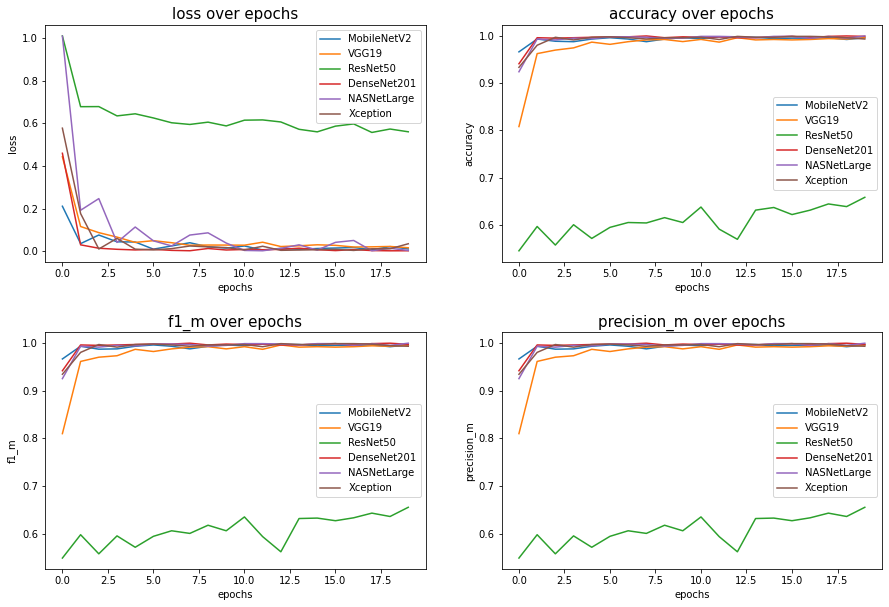

In [36]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.3)
for metric in modelHistories[0].history:
    index = list(modelHistories[0].history).index(metric)
    ax = axes.flatten()[index]
    name_index = 0
    for history in modelHistories:
        ax.plot(history.history[metric], label=modelNames[name_index])
        name_index += 1
    ax.set_title(metric+' over epochs', size=15)
    ax.set_xlabel('epochs')
    ax.set_ylabel(metric)
    #plt.savefig(metric)
    ax.legend()
    

In [ ]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
for history in modelHistories:
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig('loss_acc')

In [ ]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["f1_m"], label="train_f1")
plt.plot(np.arange(0, N), H.history["val_f1_m"], label="val_f1")
plt.title("F1 Score")
plt.xlabel("Epoch #")
plt.ylabel("Score")
plt.legend(loc="lower left")
#plt.savefig('f1')